In [2]:
# ----- Imports & settings -----
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_absolute_error, mean_squared_error
from sklearn.metrics import ConfusionMatrixDisplay
import joblib

try:
    from xgboost import XGBClassifier
    XGBOOST_AVAILABLE = True
except Exception:
    XGBOOST_AVAILABLE = False

sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (9,6)
tqdm.pandas()


In [3]:
# ----- Load master sheet -----
DATA_DIRS = [
    '../Local Business Review Project NT/data/processed'
]

MASTER_FILES = [
    'master_sheet_combined.csv'
]

def find_master():
    for d in DATA_DIRS:
        for f in MASTER_FILES:
            p = os.path.join(d, f)
            if os.path.exists(p):
                print("Loading master file:", p)
                return pd.read_csv(p)
    raise FileNotFoundError("master_sheet_combined.csv not found.")

df = find_master()
print("Loaded data shape:", df.shape)
df.head()


Loading master file: ../Local Business Review Project NT/data/processed\master_sheet_combined.csv
Loaded data shape: (6627, 6)


,business_name,address,city,category,rating,review_text
0,Bihari Express,"bihari express, 40/3, 2nd Main Rd, Somasundara...","BTM,Bangalore",restaurant,5.0,"Perfect meal, delicious and served quickly. Lo..."
1,Cinnamon - Continental Delicacies By Ambrosia,"Cinnamon - Continental Delicacies by Ambrosia,...","Whitefield,Bangalore",restaurant,5.0,Top-notch food and service. Best place in town.
2,Slurpy Shakes,"Slurpy Shakes, Hotel Regenta Central Antarim, ...","Navrangpura,Ahmedabad",restaurant,4.2,Nice place with tasty food. Slight issues with...
3,Shree Swaminarayan Food Center,"Shree Swaminarayan Food Center, a-1\011 sun vi...","Ghatlodia,Ahmedabad",restaurant,5.0,Amazing food and great service! Highly recomme...
4,Brindhavana Nithya Bhojanalaya,"BRINDHAVANA NITHYA BHOJANALAYA, 181, 1st cross...","Kumaraswamy Layout & Uttarahalli,Bangalore",restaurant,4.0,Good experience overall. Worth a repeat visit.


In [4]:
# ----- Prepare dataset (text → rating) -----
df['rating_int'] = df['rating'].round().astype(int)

X = df['review_text'].astype(str).values
y = df['rating_int'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print("Train rows:", len(X_train), "Test rows:", len(X_test))


Train rows: 5301 Test rows: 1326


In [5]:
# ----- TF-IDF vectorizer -----
tfidf = TfidfVectorizer(max_features=25000, ngram_range=(1,2), stop_words='english')
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print("TF-IDF shapes:", X_train_tfidf.shape, X_test_tfidf.shape)

OUT_DIR = '../Local Business Review Project NT/data/processed'
os.makedirs(OUT_DIR, exist_ok=True)
joblib.dump(tfidf, os.path.join(OUT_DIR, 'rating_tfidf_vectorizer.joblib'))
print("Saved TF-IDF vectorizer to", os.path.join(OUT_DIR, 'rating_tfidf_vectorizer.joblib'))


TF-IDF shapes: (5301, 25000) (1326, 25000)
Saved TF-IDF vectorizer to ../Local Business Review Project NT/data/processed\rating_tfidf_vectorizer.joblib


In [6]:
# ----- Train Logistic Regression (multiclass) -----
clf_lr = LogisticRegression(max_iter=2000, multi_class='multinomial', solver='saga', class_weight='balanced', random_state=42)
clf_lr.fit(X_train_tfidf, y_train)
print("Trained Logistic Regression.")


C:\Users\Pratham\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Trained Logistic Regression.


In [9]:
models = {'LogisticRegression': clf_lr}

# Random Forest
clf_rf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced', n_jobs=-1)
clf_rf.fit(X_train_tfidf, y_train)
models['RandomForest'] = clf_rf
print("Trained RandomForest.")

Trained RandomForest.



=== Model: LogisticRegression ===
Accuracy: 0.8673 | MAE: 0.2353 | RMSE: 0.7440

Classification report:
              precision    recall  f1-score   support

           1     0.7653    0.8065    0.7853        93
           2     0.9200    0.7041    0.7977        98
           3     0.9036    0.8152    0.8571       184
           4     0.9909    0.7918    0.8802       413
           5     0.8052    0.9833    0.8854       538

    accuracy                         0.8673      1326
   macro avg     0.8770    0.8202    0.8411      1326
weighted avg     0.8824    0.8673    0.8663      1326



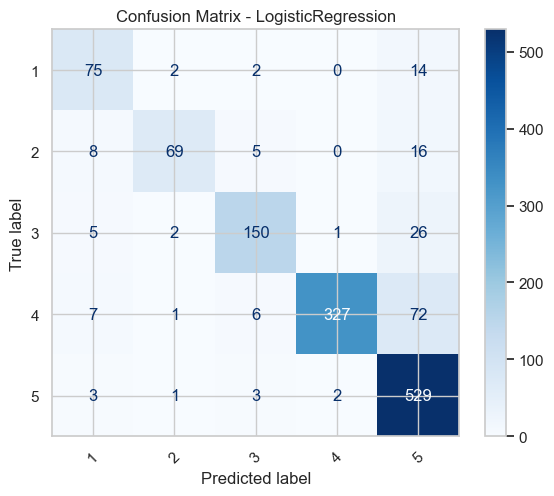


=== Model: RandomForest ===
Accuracy: 0.8514 | MAE: 0.3062 | RMSE: 0.9133

Classification report:
              precision    recall  f1-score   support

           1     0.9649    0.5914    0.7333        93
           2     1.0000    0.7041    0.8263        98
           3     1.0000    0.7772    0.8746       184
           4     1.0000    0.7845    0.8792       413
           5     0.7340    1.0000    0.8466       538

    accuracy                         0.8514      1326
   macro avg     0.9398    0.7714    0.8320      1326
weighted avg     0.8896    0.8514    0.8512      1326



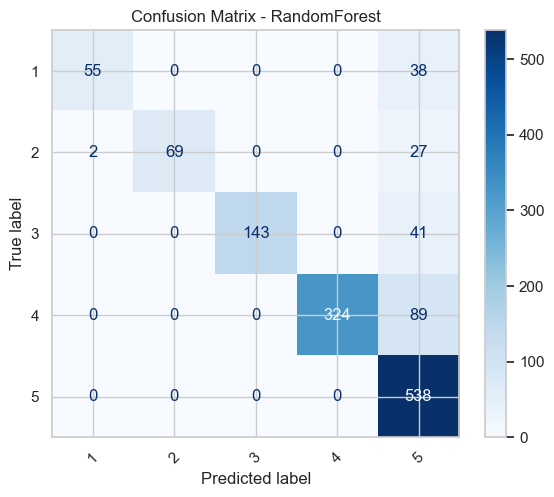

In [10]:
# ----- Evaluate trained models -----
import math
results = {}

for name, m in models.items():
    print(f"\n=== Model: {name} ===")
    y_pred = m.predict(X_test_tfidf)
    acc = accuracy_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = math.sqrt(mean_squared_error(y_test, y_pred))
    print(f"Accuracy: {acc:.4f} | MAE: {mae:.4f} | RMSE: {rmse:.4f}")
    print("\nClassification report:")
    print(classification_report(y_test, y_pred, digits=4))
    # confusion matrix
    labels = [1,2,3,4,5]
    cm = confusion_matrix(y_test, y_pred, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    fig, ax = plt.subplots(figsize=(6,5))
    disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
    plt.title(f'Confusion Matrix - {name}')
    plt.tight_layout()
    plt.show()
    # store results
    results[name] = {'model': m, 'accuracy': acc, 'mae': mae, 'rmse': rmse, 'y_pred': y_pred}


In [11]:
# ----- Select best model (by MAE or accuracy) and save -----
# simple selection: choose model with highest accuracy
best_name = max(results.keys(), key=lambda k: results[k]['accuracy'])
best_model = results[best_name]['model']
print("Best model selected:", best_name, "with accuracy:", results[best_name]['accuracy'])

# save model
joblib.dump(best_model, os.path.join(OUT_DIR, f'rating_model_{best_name}.joblib'))
print("Saved best model to", os.path.join(OUT_DIR, f'rating_model_{best_name}.joblib'))


Best model selected: LogisticRegression with accuracy: 0.8672699849170438
Saved best model to ../Local Business Review Project NT/data/processed\rating_model_LogisticRegression.joblib


In [12]:
# ----- Save predictions (test set + full dataset) -----
y_test_pred = results[best_name]['y_pred']

test_df = pd.DataFrame({
    'review_text': X_test,
    'rating_true': y_test,
    'rating_pred': y_test_pred
})
test_preds_path = os.path.join(OUT_DIR, 'rating_test_predictions.csv')
test_df.to_csv(test_preds_path, index=False)
print("Saved test predictions to:", test_preds_path)

# full dataset predictions
full_tfidf = tfidf.transform(df['review_text'].astype(str).values)
full_pred = best_model.predict(full_tfidf)
df_out = df.copy()
df_out['rating_pred'] = full_pred
full_preds_path = os.path.join(OUT_DIR, 'rating_full_predictions.csv')
df_out.to_csv(full_preds_path, index=False)
print("Saved full predictions to:", full_preds_path)


Saved test predictions to: ../Local Business Review Project NT/data/processed\rating_test_predictions.csv
Saved full predictions to: ../Local Business Review Project NT/data/processed\rating_full_predictions.csv


In [13]:
# ----- Per-category and per-city performance on test set -----
test_df2 = test_df.copy()

# per-category / per-city need mapping from sample X_test to original df rows
orig = df.reset_index().rename(columns={'index':'orig_index'})
merge_test = pd.DataFrame({'review_text': X_test, 'rating_true': y_test, 'rating_pred': y_test_pred})
merged = merge_test.merge(orig, on='review_text', how='left', suffixes=('', '_orig'))

# compute accuracy per category
if 'category' in df.columns:
    cat_acc = merged.groupby('category').apply(lambda g: accuracy_score(g['rating_true'], g['rating_pred']) if len(g)>0 else np.nan)
    print("\nAccuracy per category (test set sample):")
    display(cat_acc.sort_values(ascending=False))

# compute accuracy per city
if 'city' in df.columns:
    city_acc = merged.groupby('city').apply(lambda g: accuracy_score(g['rating_true'], g['rating_pred']) if len(g)>0 else np.nan)
    print("\nAccuracy per city (test set sample):")
    display(city_acc.sort_values(ascending=False))

mis = test_df[test_df['rating_true'] != test_df['rating_pred']].sample(n=min(8, test_df.shape[0]), random_state=42)
print("\nMisclassified examples (sample):")
display(mis)



Accuracy per category (test set sample):


C:\Users\Pratham\AppData\Local\Temp\ipykernel_19180\781736612.py:11: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cat_acc = merged.groupby('category').apply(lambda g: accuracy_score(g['rating_true'], g['rating_pred']) if len(g)>0 else np.nan)


category
gym           1.000000
restaurant    1.000000
salon         0.649402
dtype: float64


Accuracy per city (test set sample):


C:\Users\Pratham\AppData\Local\Temp\ipykernel_19180\781736612.py:17: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  city_acc = merged.groupby('city').apply(lambda g: accuracy_score(g['rating_true'], g['rating_pred']) if len(g)>0 else np.nan)


city
Arekere,Bangalore                             1.000000
BTM,Bangalore                                 1.000000
Banashankari,Bangalore                        1.000000
Central Bangalore,Bangalore                   1.000000
Basaveshwaranagar,Bangalore                   1.000000
Battarahalli,Bangalore                        1.000000
Bopal,Ahmedabad                               1.000000
Chandkheda,Ahmedabad                          1.000000
CV Raman Nagar,Bangalore                      1.000000
Frazer Town,Bangalore                         1.000000
Electronic City,Bangalore                     1.000000
Mahadevpura,Bangalore                         1.000000
Majestic,Bangalore                            1.000000
GOTA,Ahmedabad                                1.000000
Gandhinagar,Ahmedabad                         1.000000
Geddalahalli,Bangalore                        1.000000
Ghatlodia,Ahmedabad                           1.000000
HSR,Bangalore                                 1.000000
Indir


Misclassified examples (sample):


,review_text,rating_true,rating_pred
124,Love it! Love this product keeps my hair moist...,4,5
332,Whats the deal with the hype of this? AVOID! O...,1,5
1063,Okay shampoo bar but not what it claims So as ...,2,3
194,Very nice for various pairs of lashes\ really ...,4,5
494,"My skin definitely feels smoother, as far as t...",3,5
113,"Nice variety, seem to be durable At this price...",4,3
925,Not for big heads Cute designs and colors qual...,4,5
1289,Dont work to keep water out of ears in the sho...,2,5
